---
title: "Propensity Score Notebook"
date: "2025-07-17"
excerpt: "Propensity Score Notebook"
category: "Causal Inference"
tags: ["Causal Inference"]
---

[Propensity Score](https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html)

# The Psychology of Growth

치료(treatment)와 결과(outcome) 변수 외에도, 이 연구에서는 다음과 같은 다른 특성들도 기록했습니다:

- **schoolid**: 학생의 학교 식별자;
- **success_expect**: 미래 성공에 대한 자가 보고 기대치, 사전 성취도의 대용 지표로, 무작위 배정 전에 측정됨;

- **gender**: 학생이 식별한 성별의 범주형 변수;
- **frst_in_family**: 학생의 1세대 대학생 지위에 대한 범주형 변수, 즉 가족 중 대학에 진학한 첫 번째 사람;
- **school_urbanicity**: 학교의 도시화 정도에 대한 학교 수준의 범주형 변수, 즉 농촌, 교외 등;

- **school_mindset**: 학생들의 고정된 사고방식의 학교 수준 평균, 무작위 배정 전에 보고됨, 표준화됨;

- **school_achievement**: 학교 성취 수준, 이전 4개 학년 학생들의 시험 점수와 대학 준비도를 측정한 것으로, 표준화됨;

- **school_ethnic_minority**: 학교 인종/민족 소수자 구성, 즉 흑인, 라티노, 또는 아메리카 원주민인 학생 비율, 표준화됨;

- **school_poverty**: 학교 빈곤 집중도, 즉 연방 빈곤선 이하 소득을 가진 가정 출신 학생들의 비율, 표준화됨;

- **school_size**: 학교의 모든 4개 학년 학생들의 총 수, 표준화됨.

In [1]:
import pandas as pd

pd.set_option("display.max_columns", None)

data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,5,1,2,0,1,-0.462945,0.652608,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,5,13,1,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,5,2,2,1,0,-2.289636,0.190797,0.875012,-0.724801,0.761781
4488,67,0,0.358336,6,14,1,0,4,-1.115337,1.053089,0.315755,0.054586,1.862187
2637,16,1,1.360920,6,4,1,0,1,-0.538975,1.433826,-0.033161,-0.982274,1.591641


> Although the study was randomised, it doesn’t seem to be the case that this data is free from confounding

> So, although the opportunity to participate was random, participation itself is not. We are dealing with a case of non-compliance here.


마인드셋을 바꾸는 프로그램 참여 여부는 랜덤하게 주어졌지만, 실제로 참석하는데에는 학생들의 개별적인 요인의 영향이 있으니까

In [3]:
data.groupby("success_expect")["intervention"].agg(["mean", "count"])

,mean,count
success_expect,,
1,0.271739,92
2,0.265957,188
3,0.294118,476
4,0.271617,1064
5,0.311070,3803
6,0.354287,3802
7,0.362319,966


> One evidence of this is how the student’s success expectation is correlated with the participation in the seminar. 

> Students with higher self-reported success expectation are more likely to have joined the growth mindset seminar.



스스로 더 높은 기대가 있는 학생들이 실제로 더 많이 세미나에 참석하더라 -> confounding bias가 존재한다.

> Still, let’s see what the difference in means looks like. This will be a useful baseline to compare against.

$$
\hat{ATE} = \frac{1}{N} \sum_{i=1}^{N} (Y_i(1) - Y_i(0)) = E[Y_i(1)] - E[Y_i(0)]
$$

In [4]:
import statsmodels.formula.api as smf

smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


처치가 0또는 1이기 때문에 처치만을 가지고 결과를 예측하는 회귀식을 통해 $E[Y_i(1)]$과 $E[Y_i(0)]$을 추정할 수 있다.  

처치 혹은 개입이 있는 경우 없는 경우보다 평균적으로 0.4723정도 높다.    
근데 이정도 차이면 큰건가?

> But is this big or small? I know that interpreting standardized outcomes can be challenging, but bear with me for a moment. 

> I think it is worth going through this because it won’t be the last time you will encounter standardized scores.

score가 정규화되었기 때문에 이 단위는 std다.   
따라서 0.4723이란 의미는 약 0.5std 정도 차이가 있다는 의미.

> Since the treated group has an average standardized score of about 0.5, this means that they fall above 70% in terms of individual achievement.    
> Or, in other words, they are in the top 30% who achieve more. Here is what this looks like in a picture.

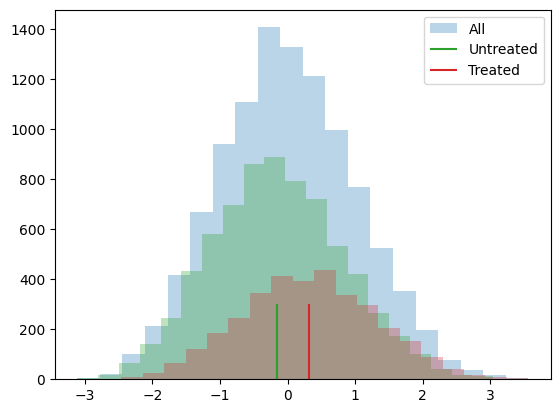

In [5]:
import matplotlib.pyplot as plt

plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend()

> Of course, we still think this result is biased.     
> The difference between treated and untreated is probably smaller than this, because we think the bias is positive

과연 이정도 차이 나는게 맞을까? 앞서 확인한 것처럼 편향이 존재한다는 것을 확인했다.    
비교군 사이에 스스로 기대하는 정도 (success_expect)가 차이가 있었고, 이는 성공확률에 영향을 미치는 요인이 될 수 있다.

# Propensity Score

> Propensity score comes from the realisation that you don’t need to directly control for confounders X to achieve conditional independence $(Y_1, Y_0) \perp T | X$ 
   
> Instead, it is sufficient to control for a balancing score $E(T|X)$

편향을 제거하고 조건부 독립성을 만족하기 위해서는 X를 통제해야하는데, 이게 어려우니까 이를 대신해서 X일때 T일 확률($e(x)$, propensity score)을 통제하자는 컨셉   


$$(Y_1, Y_0) \perp T | e(x)$$

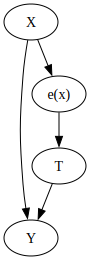

In [6]:
import graphviz as gr

g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")
g

> If I know what e(x) is, X alone tells me nothing more that can help me learn what T would be.
  
> Which means that controlling for e(x) acts the same way as controlling for X directly

데이터의 편향을 생각해보면, success expect가 높은 학생은 본인 일도 열심히하고 세미나에 참석할 확률도 높을 것이다.   
따라서 랜덤으로 기회를 줬지만 실제로는 원래 성공할 확률이 높은 학생이 세미나에 참석할 확률이 더 높음.

> Think about it. If they have the exact same probability of receiving the treatment, the only reason one of them received it and the other did not is pure chance.    
> Holding the propensity score constant acts in a way of making the data look as good as random.
  
  
참석할 확률을 같게 만든다면, 원래 목적처럼 참석할 확률이 랜덤하게 된다.

# Propensity Weighting

$$
E[Y | X, T = 1] - E[Y | X, T = 0] = E[\frac{Y}{e(x)} | X, T = 1]P(T) - E[\frac{Y}{(1 - e(x))} | X, T = 0](1 - P(T))
$$

처치를 받은 것 중에 처치를 받지 않을 것 같은 샘플 ($e(x)$가 낮은 경우)는 큰 가중치를 주고,   
반대로 처치를 받지 않은 것 중에 처치를 받을 것 같은 샘플 ($e(x)$가 높은 경우)는 큰 가중치를 주는.    
  
이러한 가중치는 직관적인 생각과 일치한다.   
왜냐하면 처치를 받은 것 중에 처치를 받을 확률이 높은 건 랜덤에 가깝게 하려면 낮춰야 하고, 처치를 받을 확률이 낮은 건 랜덤에 가깝게 하려면 높여야하기 때문이다.

> This estimator is called the Inverse Probability of Treatment Weighting (IPTW), since it scales each unit by the inverse probability of the treatment it received.

![iptw 적용한 예제](/post/Causal_Inference_for_The_Brave_and_True/iptw/iptw.png)